In [2]:
# Importing libraries to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
import quandl

from sklearn.linear_model import LinearRegression, LassoLarsIC
from sklearn.metrics import mean_squared_error

### Question 1

1. Linear regression with one explanatory variable (20 points)

- Load in monthly house prices data in pounds sterling (£) from Jan 1991 to Dec 2016 from monthlyHousePricesUK.csv and the FTSE100 index from Yahoo Finance (ticker = ^FTSE) over the same period (01-Jan-1991 to 31-Dec-2016).✅

- a) Using the FTSE100 index monthly returns as dependent variable and the house prices monthly returns as explanatory variable, create a regression model with MATLAB/Python including a constant and calculate the correlation coefficient (5points)✅
- b) What do the results tell us? (5points) ✅
- c) Use a hypothesis test to back up your conclusion about the existence of a significant relationship between these two variables. (10 points) ✅


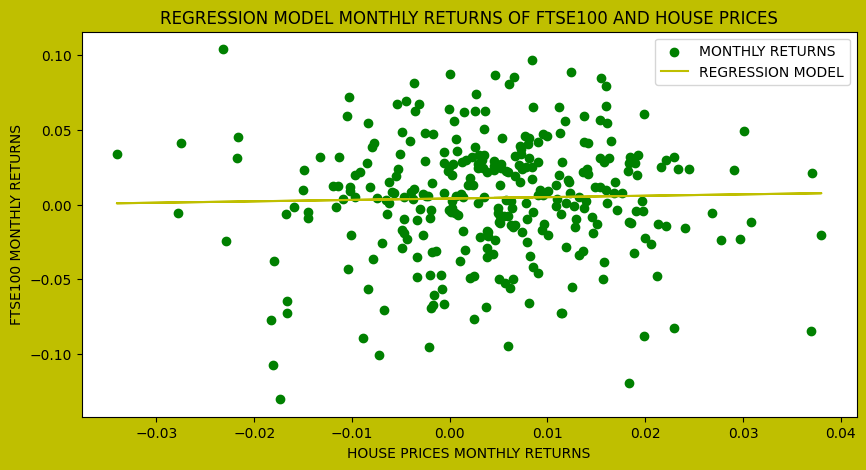

The slope: 0.09324142754349982
The correlation coefficient: 0.02655129570190995
The constant: 0.0040478376866624555
The p-value: 0.6409049000031647
The standard error: 0.19970586443555416


0           NaN
1      0.097037
2      0.031753
3      0.012090
4      0.005350
         ...   
307    0.017653
308    0.007771
309    0.035214
310   -0.009505
311   -0.023740
Name: Adj Close, Length: 312, dtype: float64

In [3]:
mHousePrice = pd.read_excel('Monthly.xls')     # Reading Monthly House Price data from excel file
ftse100 = pd.read_csv('FTSE100.csv')           # Reading FTSE100 data from excel file

mHousePriceRenamed = mHousePrice.rename(columns={'Unnamed: 0': 'Date'})           # Renaming the unnamed date field in house prices

# Extracting house price data for the period of (01-Jan-1991 to 31-Dec-2016) | No need for FTSE since its period is correct
mHousePrice19912016 = mHousePriceRenamed.loc[(mHousePriceRenamed['Date'] >= '1991-01-01') & (mHousePriceRenamed['Date'] <= '2016-12-31')]

ftse100['Date'] = pd.to_datetime(ftse100['Date']) # Converting to date time
ftse100Sorted = ftse100.sort_values(by = 'Date', ascending = True, ignore_index = True)    # Sorting the date to match the house prices data set

# MONTHLY RETURNS FOR FTSE100 AND HOUSE PRICES
ftse100MR = ftse100Sorted['Adj Close'].pct_change()
mHPMR = mHousePrice19912016['Average House Price'].pct_change()

# CREATING A REGRESSION MODEL INCLUDING A CONSTANT
slope, yIntercept, rCC, pVal, stdErr = stats.linregress(mHPMR[1:], ftse100MR[1:])

y = pd.DataFrame(ftse100MR[1:])
x = pd.DataFrame(mHPMR[1:])


# Create linear regression object - https://realpython.com/linear-regression-in-python/
regr = LinearRegression()

# Train the model
regr.fit(x, y)

# Make predictions using the testing set
prd = regr.predict(x)

# Plotting: Defining figure properties
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.facecolor"] = "y"
plt.rcParams["figure.edgecolor"] = "r"
plt.title("REGRESSION MODEL MONTHLY RETURNS OF FTSE100 AND HOUSE PRICES")
plt.ylabel("FTSE100 MONTHLY RETURNS")
plt.xlabel("HOUSE PRICES MONTHLY RETURNS")

plt.scatter(x, y, color = 'g', label = 'MONTHLY RETURNS')
plt.plot(x, prd, color = 'y', label = 'REGRESSION MODEL')
plt.legend()
plt.show()

print('The slope:', slope)
print('The correlation coefficient:', rCC)
print('The constant:', yIntercept)
print('The p-value:', pVal)
print('The standard error:', stdErr)
ftse100MR
# b) What do the results tell us?
# - The correlation coefficient of 0.02655129570190995 shows a very weak positive relationship, can be said as no relationship
# - This tells us that this data of FTSE100 and House Prices can not be used for linear regression.

# c) Hypothesis test to back up the conclusion about the existence of a significant relationship between FTSE and house prices
# Ho: There is no relationship between FTSE100 and House Prices because 
#     - The correlation coefficient is too weak.
#     - The p-value of 0.6409049000031647 is greater then the significance level of 0.05.
#     - As the p-value > α, deviating from the null hypothesis is not statistically significant, therefore, Ho is not rejected

# A p-value less than 0.05 is typically considered to be statistically significant, in which case the null hypothesis should be rejected.
# A p-value greater than 0.05 means that deviation from the null hypothesis is not statistically significant, and the null hypothesis is not rejected.

### Question 2

2. Linear regression with multiple explanatory variables (30 points)

- The college.csv file contains information about different US colleges and universities. 
- We are going to use the number of applications received, the number of enrolled students, the number of out of state students, the number of admitted students who were in the top 10% and number of admitted students who were in the top 25% of their class to predict the graduation rate.


- a) Calculate the correlation coefficients of the aforementioned variables. (5 points)
- b) Considering the graduation rate as the dependent variable, use stepwise to build the linear regression model. (5 points)
- c) Which predictor variables are useful in predicting the graduation rate? Explain how you got those variables. (5 points)
- d) Would the set of predictor variables be useful in predicting the graduation rate if you were to use BIC to select the model? Why? (5 points)
- e) Compare the accuracy of the model using only useful predictors with the accuracy of the model using all five predictors? (5 points)
- f) Given a set of predictors corresponding to Carnegie Mellon University, what graduation rate value should the most accurate model predict? (5 points)


In [4]:
college = pd.read_csv('college.csv')           # Reading US college data from csv file
collegeRenamed = college.rename(columns={'Unnamed: 0': 'Name'})           # Renaming the unnamed Name field in college

collegeX = collegeRenamed[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc' ]]
collegeY = collegeRenamed[['Grad.Rate']]

# A) calculating the correlation between several variables in a Pandas DataFrame, you can simpy use the .corr() function.
corrCoff = collegeX.corr()
print("The correlation coefficients of the 5 variables is:\n\n", corrCoff)


# SOURCE: https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447
# THE FORWARD STEPWISE REGRESSION - SELECTING PREDICTORS USING ORDINARY LEAST SQUARES

def forwardRegression(X, y, thresholdToBeIn, verbose = True):
    initList = []
    toBeIncluded = list(initList)
    model = sm.OLS(X, y) # Model using Ordinary Least Squares
    
    # Checking variables to be included
    while True:
        changed = False                         # Check if we can go to the next variable
        toBeExcluded = list(set(X.columns) - set(toBeIncluded))
        currPValue = pd.Series(index = toBeExcluded, dtype='float64')
        
        for newColumn in toBeExcluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[toBeIncluded + [newColumn]]))).fit()
            currPValue[newColumn] = model.pvalues[newColumn]
            
        bestPValue = currPValue.min()           # Setting the lowest p-value
        
        if bestPValue < thresholdToBeIn:        # Checking if the p-value is less than 0.05
            bestPredictor = currPValue.idxmin() # Selecting predictor with lowest p-value
            toBeIncluded.append(bestPredictor)    # Add it to the list of useful predictors
            changed = True                      # Go to the next predictor to be checked
            
            if verbose:
                print('\nAdding {:10} with p-value {:.4}'.format(bestPredictor, bestPValue))  # Displaying real-time process message

        if not changed:                         # When no predictor with p-value > 0.05, stop the process
            break

    return toBeIncluded                         # Returning the list of the useful predictors

model = forwardRegression(collegeX, collegeY, 0.05)

print(f'\nSelected variables to be used are : { model }')
# SOURCE: https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447

The correlation coefficients of the 5 variables is:

                Apps    Enroll  Outstate  Top10perc  Top25perc
Apps       1.000000  0.846822  0.050159   0.338834   0.351640
Enroll     0.846822  1.000000 -0.155477   0.181294   0.226745
Outstate   0.050159 -0.155477  1.000000   0.562331   0.489394
Top10perc  0.338834  0.181294  0.562331   1.000000   0.891995
Top25perc  0.351640  0.226745  0.489394   0.891995   1.000000

Adding Outstate   with p-value 1.629e-68

Adding Top25perc  with p-value 4.695e-15

Selected variables to be used are : ['Outstate', 'Top25perc']


In [5]:
# SELECTING PREDICTORS USING BAYESIAN INFORMATION CRITERION

collX = collegeRenamed[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc' ]]
collY = collegeRenamed[['Grad.Rate']]

def modelUsingBIC(x, y, verbose = True):
    initListBIC = []
    modelStatistics = ""
    bestBIC = None
    toBeIncludedBIC = list(initListBIC)
    
    while True:
        changed = False
        toBeExcludedBIC = list(set(x.columns) - set(toBeIncludedBIC))
        currPValueBIC = pd.Series(index = toBeExcludedBIC, dtype='float64')
        
        for newColumnBIC in toBeExcludedBIC:
            regrEquation = pd.DataFrame(x[toBeIncludedBIC + [newColumnBIC]])
            regrEquation = sm.add_constant(regrEquation)
            
            model = sm.OLS(y, regrEquation).fit()
            
            # predict the training set
            yhat = model.predict(regrEquation)
            
            # calculate the error
            theMSE = mean_squared_error(y, yhat)
            
            paramsNumber = len(regrEquation.columns)
            numberOfValuesY = len(y)
            theBIC = numberOfValuesY * np.log(theMSE) + paramsNumber * np.log(numberOfValuesY)
            
            currPValueBIC[newColumnBIC] = theBIC
            
        minimumBIC = currPValueBIC.min()
        
        if not bestBIC:
            bestBIC = minimumBIC
            
        if minimumBIC <= bestBIC:
            bestBIC = minimumBIC
            bestPredictorBIC = currPValueBIC.idxmin()
            modelStatistics = model.summary()
            toBeIncludedBIC.append(bestPredictorBIC)
            changed = True
            
            if verbose:
                print('\nAdding {:10} BIC score {:.10}'.format(bestPredictorBIC, minimumBIC))

        if not changed:
            break

    return (toBeIncludedBIC)

modelsBIC = modelUsingBIC(collX, collY)

print(f'\nSelected predictors to be used are: {modelsBIC}')


Adding Outstate   BIC score 4124.308995

Adding Top25perc  BIC score 4069.302502

Selected predictors to be used are: ['Outstate', 'Top25perc']


In [6]:
# MEASURING THE ACCURACY OF THE FINAL MODEL USING SELECTED PREDICTORS WITH THE DEPENDENT VARIABLE y
# AT THIS STAGE, IT IS NOT REQUIRED TO DEVIDE OUR DATASET INTO TRAINING AND TEST DATA
bestX = college[modelsBIC]
collY = collY

modelFinal = LinearRegression()       # Creating a model
modelFinal.fit(bestX, collY)          # Training the model to learn the patterns in our data: x-input set, y-output set

# Predicting the graduation rate and storing it in our dataframe
college['predictGraduation'] = modelFinal.predict(bestX)   # Asking the model to predic the graduation rate

# Measuring the accuracy of the final model
finalModelAccuracy = modelFinal.score(bestX, collY) * 100

print('The accuracy of the final model is', finalModelAccuracy)

The accuracy of the final model is 37.77644174986872


In [7]:
# MEASURING THE ACCURACY OF THE MODEL USING ALL PREDICTORS WITH THE DEPENDENT VARIABLE y
collX = collegeRenamed[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc' ]]
collY = collegeRenamed[['Grad.Rate']]

modelWithAll = LinearRegression()       # Creating a model
modelWithAll.fit(collX, collY)          # Training the model to learn the patterns in our data: x-input set, y-output set

# Predicting the graduation rate and storing it in our dataframe
college['predictGradAll'] = modelWithAll.predict(collX)

# Measuring the accuracy of the model with all variables
modelAccuracyAll = modelWithAll.score(collX, collY) * 100

print('The accuracy of the model with all variables is', modelAccuracyAll)

The accuracy of the model with all variables is 38.61582005130556


In [8]:
# PREDICTING THE GRADUATION RATE FOR CARNEGIE MELLON UNIVERSITY
collX = collegeRenamed[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc' ]]
collY = collegeRenamed[['Grad.Rate']]

# SELECTING CMU ROW FROM THE DATASET
carnegieMellon = collegeRenamed[collegeRenamed['Name'] == 'Carnegie Mellon University']

carnegieMellonX = carnegieMellon[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc' ]]

modelCMU = LinearRegression()             # Creating a model
modelCMU.fit(collX, collY)                # Training the model

# Predicting the graduation rate for CMU
gradRateCMU = modelCMU.predict(carnegieMellonX)

print('The predicted graduation rate for Carnegie Mellon University is', gradRateCMU)

The predicted graduation rate for Carnegie Mellon University is [[89.20112305]]


In [9]:
collX = collegeRenamed[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc' ]]
collY = collegeRenamed['Grad.Rate']

regrModel = LassoLarsIC(criterion='bic', normalize=False)
regrModel.fit(collX, collY)

print('The coefficients for the regression model are', regrModel.coef_)

prediction = regrModel.predict(collX)

print("The Mean Absolute Percentage Error (MAPE) is", np.mean(np.abs((collY - prediction) / collY)) * 100)

The coefficients for the regression model are [ 0.00082806 -0.00293584  0.00186158  0.          0.17922103]
The Mean Absolute Percentage Error (MAPE) is 19.11511747158517


### Question 3

3. Open study (30 points)

- Design and undertake a study to assess a trend in the domain of transport for one or more countries of your choice. 
- Your study should be based on publicly available data and explained using mathematical facts. 
- Explain assumptions, methodology and findings. An example would be to study the relationship between increase in transport and road traffic accidents. The World Health Organization has data for road traffic deaths per country in 2010 and there is a World Bank indicator for Passenger cars (per 1000 people). 
- Can you predict the situation in 2021?


- Deliverables: You should turn in a report that includes the trend you are studying, the data source (5 points), your assumptions (5points), the methodology used along with its implementation in MATLAB/Python (10 points), and finally the findings and conclusions, which should be backed with code and figures (10 points).


In [10]:
# Dataset reading
airTransport = pd.read_csv('air-transport-freight-ton-km.csv') # https://ourworldindata.org/search?q=transport
emissionCo2 = pd.read_csv('co2-emissions-by-fuel-line.csv') # https://ourworldindata.org/emissions-by-fuel
# freight.drop(['Indicator Name','Indicator Code'], axis=1, inplace=True)

# AIR TRANSPORT DATA SET ORGANIZATION ?? MAKE A FUNCTION TO APPLY ON 
yearsAirT = np.sort(airTransport['Year'].unique())

newDfAirTransport = pd.DataFrame()
newDfAirTransportYears = pd.DataFrame(columns = yearsAirT)

newDfAirTransport['Countries'] = airTransport['Entity'][airTransport['Code'].notnull()].unique()
newDfAirTransport = pd.concat([newDfAirTransport, newDfAirTransportYears], axis=1)

# for yAirT in yearsAirT:
    
#     for index, country in enumerate(newDfAirTransport['Countries']):
#         dfRowAirT = airTransport.loc[(airTransport['Year'] == yAirT) & (airTransport['Entity'] == country)]
        
#         if(len(dfRowAirT['Air transport, freight (million ton-km)'].values) != 0):
#             newDfAirTransport.loc[index][yAirT] = dfRowAirT['Air transport, freight (million ton-km)'].values[0]
            
# newDfAirTransport

# CO2 EMISSION TRANSPORT DATA SET ORGANIZATION
yrsCO2 = np.sort(emissionCo2['Year'].unique())
yearsCO2 = yrsCO2[yrsCO2 >= 1970]

newDfCO2 = pd.DataFrame()
newDfCO2Years = pd.DataFrame(columns = yearsCO2)

newDfCO2['Countries'] = emissionCo2['Entity'][emissionCo2['Code'].notnull()].unique()

newDfCO2Final = pd.concat([newDfCO2, newDfCO2Years], axis=1)

for yCO2 in yearsCO2:
    for index, countr in enumerate(newDfCO2Final['Countries']):
        dfRowCo2 = emissionCo2.loc[(emissionCo2['Year'] == yCO2) & (emissionCo2['Entity'] == countr)]
        
        if(len(dfRowCo2['Annual CO2 emissions from oil'].values) != 0):
            newDfCO2Final.loc[index][yCO2] = dfRowCo2['Annual CO2 emissions from oil'].values[0]

yearsCO2

# NEXT IS TO MERGE DATASETS FOR EASY COMPARISON: REMOVE WORLD AND OTHER IRRELEVANT
# MAY BE I DID UNNECESSARY JOB: ONLY ONE COUNTRY NEEDED


# #Selection of south Africa as a reference country
# freight_SouthAfrica = freight.iloc[263:264]
# freight_SouthAfrica1 = pd.melt(freight_SouthAfrica,id_vars = ['Country Name','Country Code'], var_name = 'years', value_name = 'Freight')
# freight_SouthAfrica1.drop(['Country Code'], axis = 1, inplace = True)

# #Dataset reading for CO2 emission

# emission_co2.drop(['Country Code','Indicator Code','Indicator Name'], axis=1, inplace=True)

# #Selection of South Africa as the reference country
# emission_SouthAfrica=emission_co2.iloc[263:264]
# emission_SouthAfrica1=pd.melt(emission_SouthAfrica,id_vars = ['Country Name'], var_name = 'years', value_name = 'CO2 emission')
# emission_SouthAfrica1

# plt.scatter(freight_SouthAfrica1['Freight'],emission_SouthAfrica1['CO2 emission'],label='Actual CO2 values')

# joined_data = freight_SouthAfrica1.join(emission_SouthAfrica1['CO2 emission'])

# joined_data1=joined_data.dropna()
# correlation = np.corrcoef(joined_data1['Freight'],joined_data1['CO2 emission'])

# x=pd.DataFrame(joined_data1['Freight'])
# y=pd.DataFrame(joined_data1['CO2 emission'])

# #finding the fitting model using scikitlearn
# regression = LinearRegression()
# regression.fit(x,y)

# prediction = regression.predict(x)
# plt.plot(x,prediction,color='red', label='Fitted CO2 emission')

# plt.title(' Regression model ', fontsize=15)
# plt.xlabel('Freight in South Africa',fontsize=15)
# plt.ylabel('CO2 emission in South Africa',fontsize=15)
# plt.legend()
# plt.show()

# x1=np.array(joined_data1['years'].astype('float')).reshape(-1,1)
# y1=joined_data1['CO2 emission']

# regression = LinearRegression()
# regression.fit(x1,y1)
# prediction1 = regression.predict(x1)

# plt.scatter(x1,y1,label='Actual CO2 values')
# plt.plot(x1,prediction1,color='red', label='predicted CO2 emission')
# plt.title(' Regression model ', fontsize=15)
# plt.xlabel('Years',fontsize=15)
# plt.ylabel('CO2 emission predicted in 2021',fontsize=15)
# plt.legend()
# plt.show()

# CO2_2021 = regression.predict([['2021']])
# print('The CO2 emission in 2021:',CO2_2021)

# tset, pval =stats.ttest_ind(joined_data1['Freight'],joined_data1['CO2 emission'])
# print('The p_value is: ',pval)

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

### Question 4

4. Model Fitting and Prediction (20 points)

- The bank of Israel has published the data for unemployment rate (per 100 Israeli workforces) from 1980-12-31 to 2013-09-02. Download the data from Quandl (code: ODA/ISR_LUR) into MATLAB/Python. 
- Estimate the likely rate of unemployment by the year 2020 (10 points). 
- Explain how one can evaluate the accuracy of the estimate (5 points) and provide the accuracy as a percentage. (5 points)

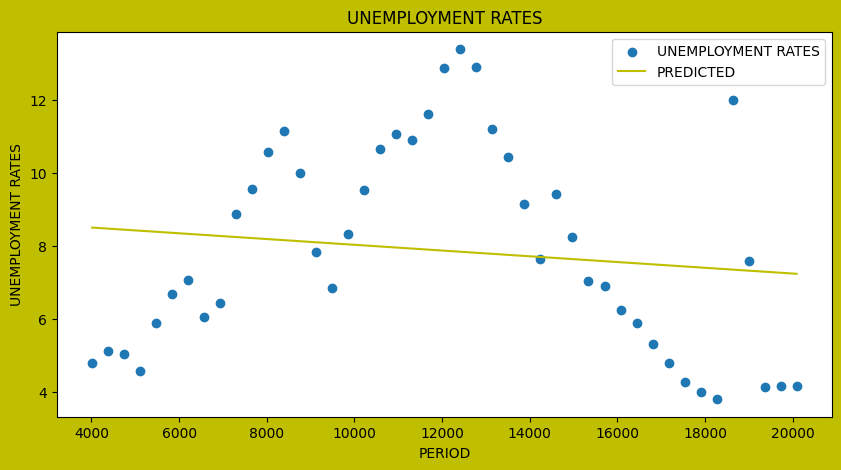

The Mean Absolute Percentage Error (MAPE) is 35.36131987166638
The employment rate in 2022 will be [7.29779391]


In [11]:
quandl.ApiConfig.api_key = 'V7N2sptsmqduHdyuAhSn'   # Specifying the API KEY
unEmpRate = quandl.get('ODA/ISR_LUR')               # Getting unemployment rate data

# Accessing or selecting the data between 1980-12-31 and 2013-09-02 period
unEmpRatePeriod = unEmpRate.loc['1980-12-31':'2013-12-31']

xAsDateTime = unEmpRate.index.values.astype('datetime64[D]') # ?
xAsFloat = xAsDateTime.astype(float)   # ?
xReshaped = xAsFloat.reshape(-1,1)   # ?

y = unEmpRate['Value']
model = LinearRegression()

model.fit((xReshaped), y)
predictY = model.predict(xReshaped)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.facecolor"] = "y"
plt.rcParams["figure.edgecolor"] = "r"
plt.title("UNEMPLOYMENT RATES")
plt.ylabel("UNEMPLOYMENT RATES")
plt.xlabel("PERIOD")

plt.scatter(xReshaped, y, label='UNEMPLOYMENT RATES')
plt.plot(xReshaped, predictY, color = 'y', label = 'PREDICTED')
plt.legend()
plt.show()

Date2022 = np.datetime64('2022-12-31')
DateToday = Date2022.astype(float).reshape(-1, 1)

print("The Mean Absolute Percentage Error (MAPE) is", np.mean(np.abs((y - predictY) / y)) * 100)

print("The employment rate in 2022 will be", model.predict(DateToday))